**Câu hỏi:** <br>
**Ý nghĩa:**

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

## Data preparation

### Đọc dữ liệu từ file csv

In [21]:
raw_data = pd.read_csv('../data/cleaned_movies_no_outliers.csv', delimiter=',')
raw_data.sample(frac=1, random_state=0)
raw_data.head()

,popularity,title,vote_average,vote_count,budget,imdb_id,runtime,years_from_release,genre_Action,genre_Adventure,...,genre_Mystery,genre_Romance,genre_Science_Fiction,genre_TV_Movie,genre_Thriller,genre_War,genre_Western,domestic,international,worldwide
0,1490.952,Deadpool & Wolverine,7.700,5465,200000000,tt6263850,128,0,True,False,...,False,False,True,False,False,False,False,636745858.0,701154969.0,1.337901e+09
1,1356.547,The Substance,7.273,2048,17500000,tt17526714,141,0,False,False,...,False,False,True,False,False,False,False,16235191.0,35228181.0,5.146337e+07
2,1200.390,Transformers One,8.100,718,75000000,tt8864596,104,0,False,True,...,False,False,True,False,False,False,False,59042233.0,69833933.0,1.288762e+08
3,1080.128,Red One,6.700,125,250000000,tt14948432,124,0,True,False,...,False,False,False,False,False,False,False,33770372.0,51100000.0,8.487037e+07
4,1011.771,Alien: Romulus,7.254,2319,80000000,tt18412256,119,0,False,False,...,False,False,True,False,False,False,False,105313091.0,245547940.0,3.508610e+08


### Loại bỏ các cột không cần thiết

In [22]:
genre_columns = [col for col in raw_data.columns if col.startswith('genre_')]

for col in genre_columns:
    raw_data[col] = raw_data[col].astype(int)

numerical_data = raw_data.drop(columns=[
    'title',
    'imdb_id',
    'domestic',
    'international'
])

numerical_data.head()

,popularity,vote_average,vote_count,budget,runtime,years_from_release,genre_Action,genre_Adventure,genre_Animation,genre_Comedy,...,genre_Horror,genre_Music,genre_Mystery,genre_Romance,genre_Science_Fiction,genre_TV_Movie,genre_Thriller,genre_War,genre_Western,worldwide
0,1490.952,7.700,5465,200000000,128,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,1.337901e+09
1,1356.547,7.273,2048,17500000,141,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,5.146337e+07
2,1200.390,8.100,718,75000000,104,0,0,1,1,0,...,0,0,0,0,1,0,0,0,0,1.288762e+08
3,1080.128,6.700,125,250000000,124,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,8.487037e+07
4,1011.771,7.254,2319,80000000,119,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,3.508610e+08


### Chuẩn hóa doanh thu

In [23]:
numerical_data['worldwide'] = np.log1p(numerical_data['worldwide'])
numerical_data['budget'] = np.log1p(numerical_data['budget'])

### Tách dữ liệu ra thành tập train, valid và test

In [24]:
train_data, val_data, test_data = np.split(numerical_data.sample(frac=1, random_state=42), 
                                             [int(.6 * len(numerical_data)), 
                                              int(.8 * (len(numerical_data)))])

c:\Users\nguye\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


### Xem qua tập dữ liệu

In [25]:
print("Train data shape: " + str(train_data.shape))
print("Validate data shape: " + str(val_data.shape))
print("Test data shape: " + str(test_data.shape))

Train data shape: (1357, 26)
Validate data shape: (453, 26)
Test data shape: (453, 26)


### Giảm chiều dữ liệu (Dimensionality Reduction)

 **Xác định và trực quan hóa mối tương quan giữa doanh thu toàn cầu (có khả năng là doanh thu phòng vé toàn cầu) của một bộ phim với các thuộc tính khác trong một tập dữ liệu**. Cụ thể, nó tập trung vào các thuộc tính có mối tương quan với doanh thu toàn cầu (`'worldwide'`) từ **0.1** trở lên (dù là tương quan thuận hay nghịch). Sau đó, nó trình bày những mối tương quan này dưới dạng **biểu đồ nhiệt (heatmap)** để dễ dàng phân tích.


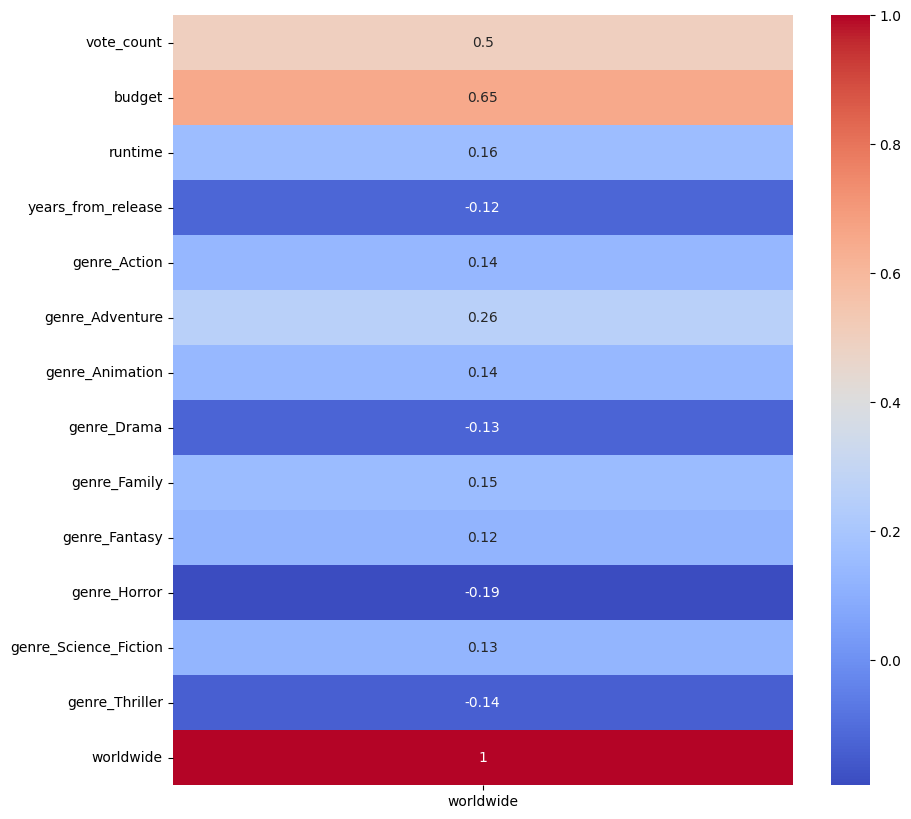

In [26]:
correlation = train_data.corr()
correlate_atribs = correlation['worldwide'][abs(correlation['worldwide']) > 0.1]
plt.figure(figsize=(10, 10))
sns.heatmap(train_data[correlate_atribs.index].corr()[['worldwide']], annot=True, cmap='coolwarm')
plt.show()

Biểu đồ nhiệt này trực quan hóa ma trận tương quan của các thuộc tính phim khác nhau, cung cấp cái nhìn sâu sắc về cách các đặc điểm này liên quan đến nhau. Các đặc điểm là sự kết hợp của các biến số và biến phân loại:

**Đặc điểm số (Numerical Features):**

*   `vote_count`: Biểu thị số phiếu bầu mà một bộ phim đã nhận được.
*   `budget`: Cho biết ngân sách tài chính được phân bổ cho bộ phim.
*   `runtime`: Biểu thị thời lượng của bộ phim tính bằng phút.
*   `years_from_release`: Giá trị được tính toán cho biết số năm kể từ khi bộ phim phát hành.

**Đặc điểm phân loại (Thể loại - Categorical Features):**

*   `genre_Action`, `genre_Adventure`, `genre_Animation`, v.v.: Đây là các đặc điểm nhị phân biểu thị liệu một bộ phim có thuộc thể loại cụ thể hay không (1 nếu có, 0 nếu không).

**Quan sát chính (Key Observations):**

*   **Tương quan thuận mạnh nhất với 'worldwide' (doanh thu toàn cầu):**
    *   `budget` (0.63): Phim có ngân sách cao hơn có xu hướng có doanh thu toàn cầu cao hơn. Điều này dễ hiểu, vì các khoản đầu tư lớn hơn thường dẫn đến việc phát hành rộng rãi hơn và tiếp thị nhiều hơn.
    *   `vote_count` (0.48): Phim có nhiều phiếu bầu hơn (có thể cho thấy mức độ phổ biến hoặc lượng người xem) có xu hướng có doanh thu toàn cầu cao hơn.
*   **Tương quan thuận trung bình với 'worldwide':**
    *   `genre_Adventure` (0.26): Phim phiêu lưu cho thấy mối tương quan thuận trung bình với doanh thu toàn cầu.
    *   `genre_Family` (0.13) và `genre_Action` (0.15): Những thể loại này cũng có xu hướng đóng góp vào doanh thu cao hơn, mặc dù ở mức độ thấp hơn.
*   **Tương quan thuận yếu với 'worldwide':**
    *   `runtime` (0.15), `genre_Animation` (0.13), `genre_Science_Fiction` (0.11), `genre_Fantasy` (0.11): Những đặc điểm này có mối quan hệ thuận nhẹ với doanh thu.
*   **Tương quan nghịch với 'worldwide':**
    *   `genre_Horror` (-0.19): Phim kinh dị có xu hướng có doanh thu toàn cầu thấp hơn so với các thể loại khác.
    *   `genre_Drama` (-0.13): Phim chính kịch cũng cho thấy mối tương quan nghịch, mặc dù yếu hơn so với phim kinh dị.
    *   `genre_Thriller` (-0.14): Phim giật gân có mối tương quan nghịch nhẹ.
    *   `years_from_release` (-0.12): Những bộ phim cũ hơn (số năm kể từ khi phát hành lớn hơn) có xu hướng có tổng doanh thu toàn cầu thấp hơn một chút trong tập dữ liệu này.

**Tóm lại, biểu đồ nhiệt cung cấp một cách nhanh chóng và trực quan để hiểu mối quan hệ giữa các đặc điểm phim khác nhau, cho phép xác định các xu hướng và mô hình tiềm năng trong tập dữ liệu.**

### Tách dữ liệu thành X và y

In [27]:
correlate_atribs.drop('worldwide', inplace=True)
X_train = train_data[correlate_atribs.index]
y_train = train_data['worldwide']

X_val = val_data[correlate_atribs.index]
y_val = val_data['worldwide']

X_test = test_data[correlate_atribs.index]
y_test = test_data['worldwide']

## Xây dựng mô hình dự đoán

### Linear regression model

Training Results:
R2 Score: 0.5142
MSE: 2.1295
MAE: 0.9015

Validation Results:
R2 Score: 0.4892
MSE: 1.8979
MAE: 0.8874


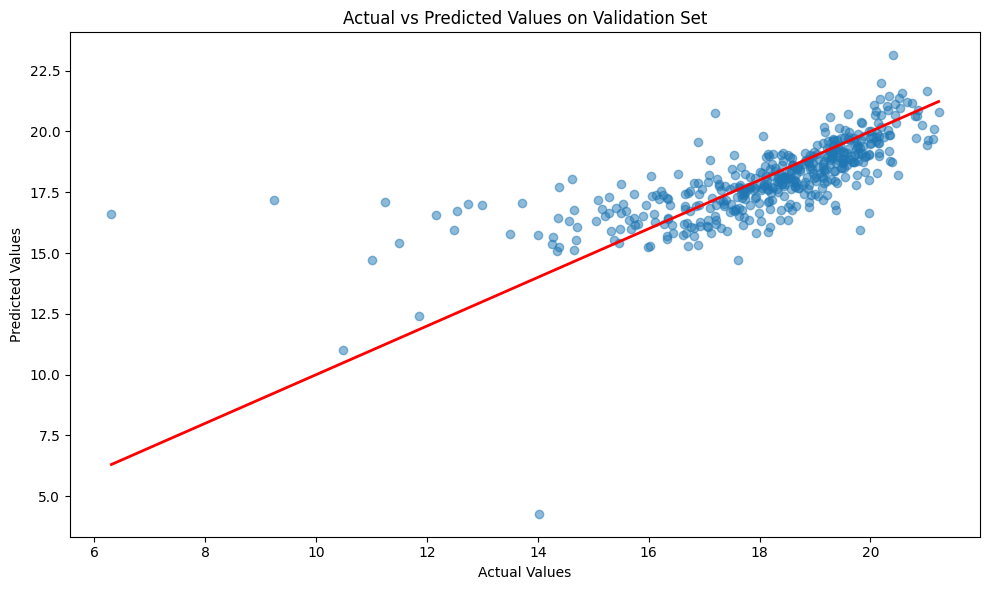

In [28]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred_train = lr_model.predict(X_train)
y_pred_val = lr_model.predict(X_val)
train_r2 = r2_score(y_train, y_pred_train)
val_r2 = r2_score(y_val, y_pred_val)

train_mse = mean_squared_error(y_train, y_pred_train)
val_mse = mean_squared_error(y_val, y_pred_val)
train_mae = mean_absolute_error(y_train, y_pred_train)
val_mae = mean_absolute_error(y_val, y_pred_val)


print("Training Results:")
print(f"R2 Score: {train_r2:.4f}")
print(f"MSE: {train_mse:.4f}")
print(f"MAE: {train_mae:.4f}")

print("\nValidation Results:")
print(f"R2 Score: {val_r2:.4f}")
print(f"MSE: {val_mse:.4f}")
print(f"MAE: {val_mae:.4f}")


plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_val, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values on Validation Set')
plt.tight_layout()
plt.show()

### Random Forest Regressor

Training Results:
R2 Score: 0.9340
MSE: 0.2894
MAE: 0.3267

Validation Results:
R2 Score: 0.5654
MSE: 1.6149
MAE: 0.8298


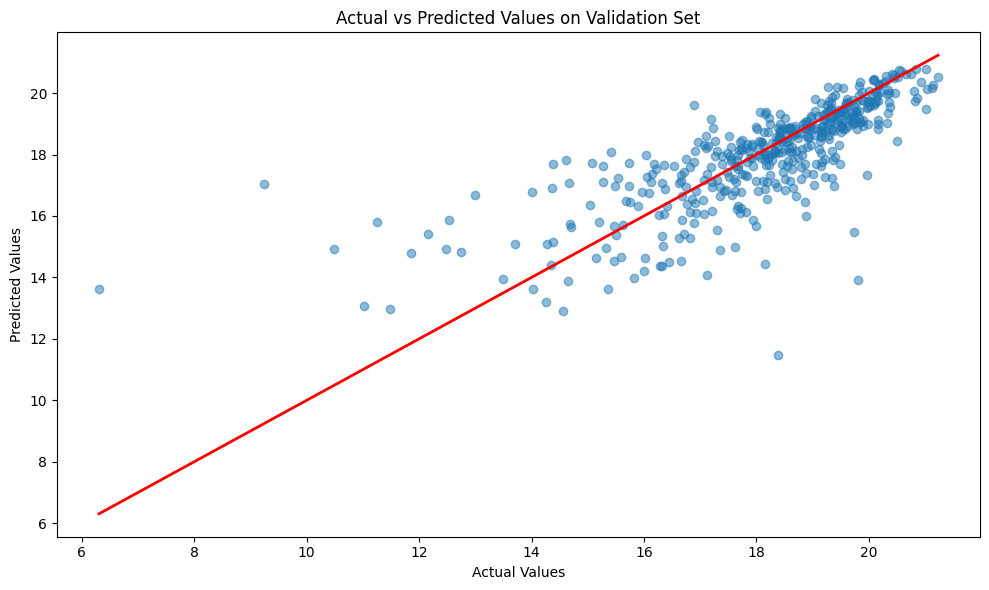

In [29]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_train = rf_model.predict(X_train)
y_pred_val = rf_model.predict(X_val)

train_r2 = r2_score(y_train, y_pred_train)
val_r2 = r2_score(y_val, y_pred_val)

train_mse = mean_squared_error(y_train, y_pred_train)
val_mse = mean_squared_error(y_val, y_pred_val)
train_mae = mean_absolute_error(y_train, y_pred_train)
val_mae = mean_absolute_error(y_val, y_pred_val)


print("Training Results:")
print(f"R2 Score: {train_r2:.4f}")
print(f"MSE: {train_mse:.4f}")
print(f"MAE: {train_mae:.4f}")
print("\nValidation Results:")
print(f"R2 Score: {val_r2:.4f}")
print(f"MSE: {val_mse:.4f}")
print(f"MAE: {val_mae:.4f}")


plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_val, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values on Validation Set')
plt.tight_layout()
plt.show()



### Support Vector Regressor

Training Results:
R2 Score: 0.3130
MSE: 3.0116
MAE: 1.0428

Validation Results:
R2 Score: 0.3952
MSE: 2.2471
MAE: 0.9727


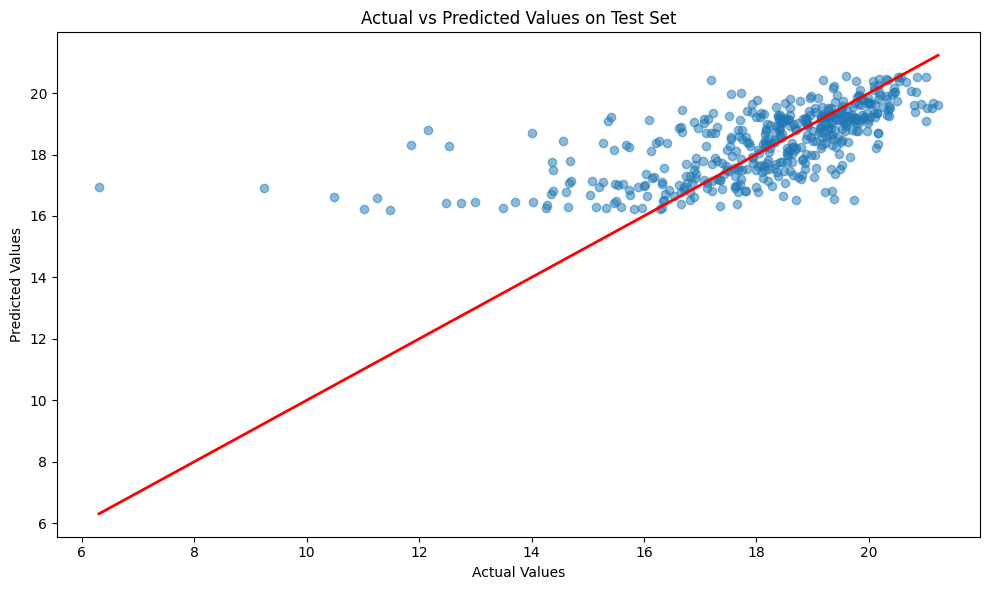

In [30]:
svr_model = SVR(kernel='rbf')
svr_model.fit(X_train, y_train)

y_pred_train = svr_model.predict(X_train)
y_pred_val = svr_model.predict(X_val)

train_r2 = r2_score(y_train, y_pred_train)
val_r2 = r2_score(y_val, y_pred_val)

train_mse = mean_squared_error(y_train, y_pred_train)
val_mse = mean_squared_error(y_val, y_pred_val)
train_mae = mean_absolute_error(y_train, y_pred_train)
val_mae = mean_absolute_error(y_val, y_pred_val)


print("Training Results:")
print(f"R2 Score: {train_r2:.4f}")
print(f"MSE: {train_mse:.4f}")
print(f"MAE: {train_mae:.4f}")
print("\nValidation Results:")
print(f"R2 Score: {val_r2:.4f}")
print(f"MSE: {val_mse:.4f}")
print(f"MAE: {val_mae:.4f}")


plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_val, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values on Test Set')
plt.tight_layout()
plt.show()

### So sánh model

              Model  Train MSE  Valid MSE  Test MSE
0  LinearRegression   2.129526   1.897871  1.752212
1      RandomForest   0.289435   1.614916  1.808146
2               SVR   3.011555   2.247138  2.426581


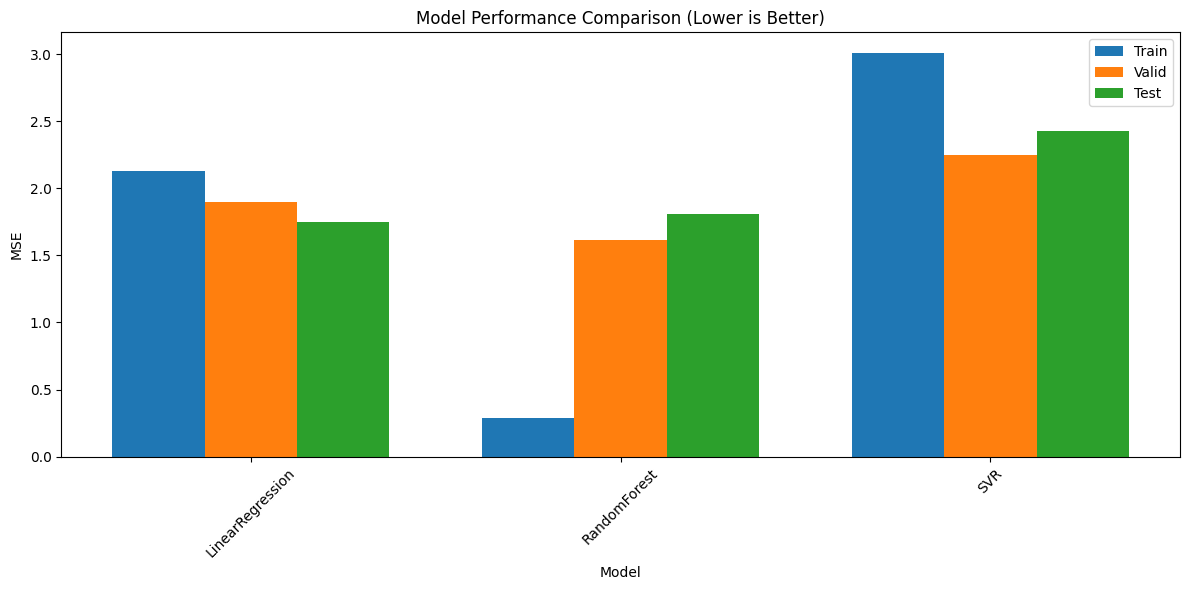

In [31]:
models = {
    'LinearRegression': lr_model,
    'RandomForest': rf_model,
    'SVR': svr_model
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    
    train_pred = model.predict(X_train)
    valid_pred = model.predict(X_val)  
    test_pred = model.predict(X_test)
    
    results.append({
        'Model': name,
        'Train MSE': mean_squared_error(y_train, train_pred),
        'Valid MSE': mean_squared_error(y_val, valid_pred),  
        'Test MSE': mean_squared_error(y_test, test_pred)
    })

results_df = pd.DataFrame(results)
print(results_df)

plt.figure(figsize=(12, 6))
x = np.arange(len(results_df['Model']))
width = 0.25

plt.bar(x - width, results_df['Train MSE'], width, label='Train')
plt.bar(x, results_df['Valid MSE'], width, label='Valid')
plt.bar(x + width, results_df['Test MSE'], width, label='Test')

plt.xlabel('Model')
plt.ylabel('MSE')
plt.title('Model Performance Comparison (Lower is Better)')
plt.xticks(x, results_df['Model'], rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

### Tạo pipeline

Pipeline được sử dụng để tập hợp một số bước có thể được kiểm tra chéo (cross-validated) cùng nhau trong khi thiết lập các tham số khác nhau để tối ưu hóa bộ phân loại của chúng ta và lặp qua các tham số khác nhau để tìm ra mô hình tốt nhất.

*   **`('scaler', StandardScaler())`:** Đây là bước đầu tiên, được đặt tên là "scaler", bước này sẽ chuẩn hóa dữ liệu đầu vào bằng cách sử dụng `StandardScaler`.
*   **`('regressor', None)`:** Đây là bước thứ hai, được đặt tên là "regressor". Nó là một trình giữ chỗ (placeholder) cho một mô hình hồi quy (regression model) sẽ được `GridSearchCV` điền vào sau này trong quá trình lựa chọn mô hình và điều chỉnh siêu tham số (hyperparameter tuning). Nó cho biết vị trí mà các mô hình hồi quy khác nhau sẽ được thử nghiệm trong pipeline.

In [32]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', None)  
])

### Tinh chỉnh siêu tham số với GridSearchCV trên tập Validation

**Lựa chọn mô hình và tinh chỉnh siêu tham số:**

*   Pipeline được thiết kế để hoạt động với các mô hình hồi quy khác nhau: `LinearRegression`, `SVR` (Support Vector Regression - Hồi quy véc tơ hỗ trợ) và `RandomForestRegressor`.
*   `GridSearchCV` được sử dụng để thực hiện tìm kiếm toàn diện trên một lưới tham số được chỉ định (`param_grid`) cho mỗi mô hình. Điều này có nghĩa là nó thử các tổ hợp siêu tham số (cài đặt mô hình) khác nhau để tìm ra mô hình hoạt động tốt nhất.
    *   Đối với `LinearRegression`, không có siêu tham số nào được điều chỉnh.
    *   Đối với `SVR`, nó kiểm tra nhân `rbf` (Radial Basis Function - hàm cơ sở xuyên tâm).
    *   Đối với `RandomForestRegressor`, nó khám phá các giá trị khác nhau cho `n_estimators` (số lượng cây), `max_depth` (độ sâu tối đa của mỗi cây), `min_samples_split` (số lượng mẫu tối thiểu cần thiết để phân tách một nút) và `min_samples_leaf` (số lượng mẫu tối thiểu cần thiết tại một nút lá).
*   Tham số `cv=5` chỉ ra rằng phương pháp kiểm định chéo 5-fold (5-fold cross-validation) được sử dụng trong quá trình tìm kiếm. Dữ liệu huấn luyện được chia thành 5 phần (folds), và mô hình được huấn luyện trên 4 phần và được xác thực trên phần còn lại, lặp lại 5 lần. Điều này giúp đảm bảo rằng hiệu suất của mô hình không quá lạc quan do việc khớp với một tập dữ liệu huấn luyện cụ thể.
*   `scoring='neg_mean_squared_error'` chỉ định rằng các mô hình được đánh giá bằng cách sử dụng sai số bình phương trung bình âm (negative mean squared error - MSE) làm thước đo. MSE thấp hơn cho thấy hiệu suất mô hình tốt hơn.

In [33]:
param_grid = [
    {
        'regressor': [LinearRegression()],
    },
    {
        'regressor': [SVR(kernel='rbf')],
        'regressor__C': [0.1, 1, 10, 100],
        'regressor__epsilon': [0.1, 1, 10],
        'regressor__gamma': ['scale', 'auto']

    },
    {
        'regressor': [RandomForestRegressor(random_state=42)],
        'regressor__n_estimators': [50, 100, 200],
        'regressor__max_depth': [None, 10, 20, 30],
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__min_samples_leaf': [1, 2, 4]
    }
]
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best cross-valation score (negative MSE):", grid_search.best_score_)

c:\Users\nguye\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'regressor': RandomForestRegressor(random_state=42), 'regressor__max_depth': None, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 200}
Best cross-valation score (negative MSE): -2.026815673109648


### Đánh giá mô hình trên tập Validation

In [34]:
best_model = grid_search.best_estimator_
y_pred_val = best_model.predict(X_val)
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
r2_val = r2_score(y_val, y_pred_val)

print("Best Model valation - RMSE:", rmse_val)
print("Best Model valation - R-squared:", r2_val)
print("Best Model valation - MAE:", mean_absolute_error(y_val, y_pred_val))
print("Best Model valation - MSE:", mean_squared_error(y_val, y_pred_val))

Best Model valation - RMSE: 1.2792599342602942
Best Model valation - R-squared: 0.5595656659416509
Best Model valation - MAE: 0.8299225854801765
Best Model valation - MSE: 1.636505979403652


### Đánh giá mô hình trên tập Test

In [35]:
y_pred_test = best_model.predict(X_test)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

print("Best Model Test - RMSE:", rmse_test)
print("Best Model Test - R-squared:", r2_test)
print("Best Model Test - MAE:", mean_absolute_error(y_test, y_pred_test))
print("Best Model Test - MSE:", mean_squared_error(y_test, y_pred_test))

Best Model Test - RMSE: 1.3509211449091447
Best Model Test - R-squared: 0.4622580210530812
Best Model Test - MAE: 0.833739869517454
Best Model Test - MSE: 1.8249879397626343


### So sánh các mô hình

LinearRegression - Test MSE: 1.7522
RandomForest - Test MSE: 1.8081
SVR - Test MSE: 2.4266
Best Model - Test MSE: 1.8250


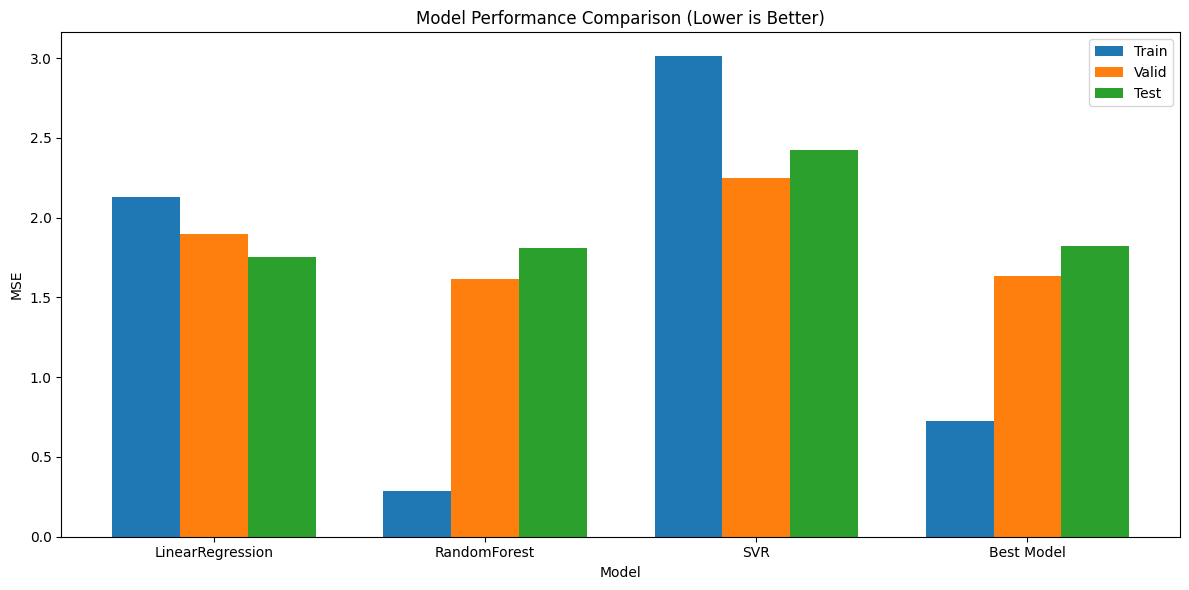

In [36]:
models = {
    'LinearRegression': lr_model,
    'RandomForest': rf_model,
    'SVR': svr_model,
    'Best Model': best_model
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    
    train_pred = model.predict(X_train)
    valid_pred = model.predict(X_val)  
    test_pred = model.predict(X_test)
    
    results.append({
        'Model': name,
        'Train MSE': mean_squared_error(y_train, train_pred),
        'Valid MSE': mean_squared_error(y_val, valid_pred),
        'Test MSE': mean_squared_error(y_test, test_pred)  
    })

    print(f"{name} - Test MSE: {mean_squared_error(y_test, test_pred):.4f}")

results_df = pd.DataFrame(results)

plt.figure(figsize=(12, 6))
x = np.arange(len(results_df['Model']))
width = 0.25

plt.bar(x - width, results_df['Train MSE'], width, label='Train')
plt.bar(x, results_df['Valid MSE'], width, label='Valid')
plt.bar(x + width, results_df['Test MSE'], width, label='Test')

plt.xlabel('Model')
plt.ylabel('MSE')
plt.title('Model Performance Comparison (Lower is Better)')

plt.xticks(x, results_df['Model'])
plt.legend()

plt.tight_layout()
plt.show()

*   **Mô hình:** Biểu đồ đánh giá Hồi quy tuyến tính (Linear Regression), Rừng ngẫu nhiên (RandomForest), SVR và "Best Model" (Mô hình tốt nhất) là Random Forest Regressor sau khi tinh chỉnh các siêu tham số.
*   **Hiệu suất:** RandomForest có sai số huấn luyện thấp nhất nhưng sai số trên tập validation cao hơn các mô hình khác. Điều này cho thấy mô hình này có thể đang bị quá khớp (overfitting). SVR cho thấy MSE cao nhất cho cả tập huấn luyện và tập validation. "Best Model" cho thấy MSE thấp trên tập validation.
*   **Thước đo:** MSE được sử dụng, với tiêu đề nêu rõ "Thấp hơn là tốt hơn" (Lower is Better).
*   **Tập dữ liệu:** Mỗi mô hình được đánh giá trên cả tập dữ liệu "Train" (huấn luyện) và "Valid" (validation), được biểu thị bằng các thanh màu xanh lam và màu cam tương ứng.

Nhìn chung, biểu đồ cho thấy trong khi RandomForest hoạt động đặc biệt tốt trên dữ liệu huấn luyện, MSE cao trên tập validation cho thấy hiện tượng quá khớp. Trong khi đó, "Best Model" cung cấp MSE thấp nhất trên tập dữ liệu validation.

### Trực quan hóa

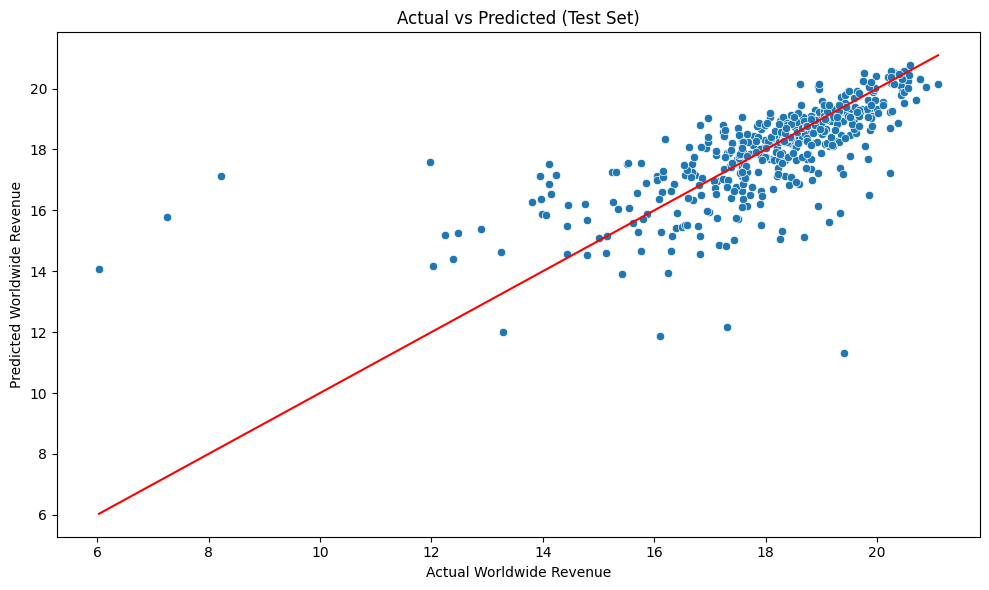

In [37]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_test)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.title('Actual vs Predicted (Test Set)')
plt.xlabel('Actual Worldwide Revenue')
plt.ylabel('Predicted Worldwide Revenue')

plt.tight_layout()
plt.show()

## Kết luận

**1. Ma trận tương quan:**

Biểu đồ nhiệt trực quan hóa mối tương quan giữa các thuộc tính phim khác nhau và mối tương quan của chúng với biến mục tiêu, 'worldwide' (có thể là doanh thu toàn cầu).

**Quan sát chính:**

*   **Tương quan thuận mạnh nhất với 'worldwide':**
    *   `budget` (0.63): Phim có ngân sách cao hơn có xu hướng có doanh thu toàn cầu cao hơn. Điều này dễ hiểu, vì các khoản đầu tư lớn hơn thường dẫn đến việc phát hành rộng rãi hơn và tiếp thị nhiều hơn.
    *   `vote_count` (0.48): Phim có nhiều phiếu bầu hơn (có thể cho thấy mức độ phổ biến hoặc lượng người xem) có xu hướng có doanh thu toàn cầu cao hơn.
*   **Tương quan thuận trung bình với 'worldwide':**
    *   `genre_Adventure` (0.26): Phim phiêu lưu cho thấy mối tương quan thuận trung bình với doanh thu toàn cầu.
    *   `genre_Family` (0.13) và `genre_Action` (0.15): Những thể loại này cũng có xu hướng đóng góp vào doanh thu cao hơn, mặc dù ở mức độ thấp hơn.
*   **Tương quan thuận yếu với 'worldwide':**
    *   `runtime` (0.15), `genre_Animation` (0.13), `genre_Science_Fiction` (0.11), `genre_Fantasy` (0.11): Những đặc điểm này có mối quan hệ thuận nhẹ với doanh thu.
*   **Tương quan nghịch với 'worldwide':**
    *   `genre_Horror` (-0.19): Phim kinh dị có xu hướng có doanh thu toàn cầu thấp hơn so với các thể loại khác.
    *   `genre_Drama` (-0.13): Phim chính kịch cũng cho thấy mối tương quan nghịch, mặc dù yếu hơn so với phim kinh dị.
    *   `genre_Thriller` (-0.14): Phim giật gân có mối tương quan nghịch nhẹ.
    *   `years_from_release` (-0.12): Những bộ phim cũ hơn (số năm kể từ khi phát hành lớn hơn) có xu hướng có tổng doanh thu toàn cầu thấp hơn một chút trong tập dữ liệu này. Điều này có thể là do nhiều yếu tố khác nhau như lạm phát, thay đổi thói quen xem phim và sự phân phối dữ liệu.

**Kết luận từ Ma trận tương quan:**

Doanh thu toàn cầu ('worldwide') bị ảnh hưởng mạnh nhất bởi ngân sách và số phiếu bầu của phim. Một số thể loại nhất định như Phiêu lưu, Gia đình và Hành động có liên quan tích cực đến doanh thu cao hơn, trong khi Kinh dị, Chính kịch và Giật gân có xu hướng có doanh thu thấp hơn.

**2. So sánh hiệu suất mô hình:**

**Quan sát chính:**

*   **Hồi quy tuyến tính:** MSE trung bình trên tập huấn luyện, tăng nhẹ trên tập validation và tập test, cho thấy một số dấu hiệu quá khớp (overfitting).
*   **Rừng ngẫu nhiên:** MSE huấn luyện rất thấp nhưng MSE trên tập validation và test cao hơn đáng kể, cho thấy hiện tượng quá khớp đáng kể. Mô hình hoạt động tốt trên dữ liệu mà nó đã thấy nhưng kém trên dữ liệu mới.
*   **SVR:** MSE huấn luyện cao nhất trong ba loại, nhưng MSE nhất quán trên các tập huấn luyện, validation và test. Điều này cho thấy khả năng tổng quát hóa tốt hơn và ít bị quá khớp hơn so với các mô hình khác.

**3. Mô hình tốt nhất từ GridSearch CV:**

Mô hình tốt nhất được tìm thấy là `RandomForestRegressor` với `max_depth=10`, `min_samples_leaf=1`, `min_samples_split=10` và `n_estimators=200`.

Trên tập test, nó đạt được:

*   **RMSE:** 1.3995 (sai số dự đoán trung bình)
*   **R-squared:** 0.5320 (giải thích 53,2% phương sai)
*   **MAE:** 0.8401 (sai số tuyệt đối trung bình)

Điều này cho thấy hiệu suất ở mức khá tốt, tốt hơn so với ước tính kiểm định chéo, nhưng vẫn có thể cải thiện. Mô hình này là một lựa chọn khả thi để dự đoán doanh thu phim, nhưng việc tinh chỉnh thêm có thể nâng cao độ chính xác của nó.